In [2]:
import pandas as pd
import numpy as np
from scipy.special import logit, expit

from sklearn.linear_model import ElasticNetCV, BayesianRidge
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, mean_squared_error

import matplotlib.pyplot as plt
from scipy.stats import norm as N

In [3]:
df = pd.read_csv('all_data_logit.csv')

df.loc[(df['state'] == 'DC'), df.columns[df.columns.str.contains('house')]] = 0
df.loc[(df['state'] == 'DC'), 'white_evangelist_pct'] = logit(0.01)

In [8]:
features = [
    'result_house_2', 
    'result_pres_4', 
    'result_pres_8', 
    'result_house_8',
    'result_pres_12',
    'bachelor_higher_pct',
    'asian',
    'unemployment_pct',
    'unemployment_pct_1',
    'white_evangelist_pct',
    'result'
]

to_fold = df[features].dropna(how = 'any')
split = list(KFold(shuffle = True).split(to_fold))

mean_scores = []
w_space = np.linspace(0.65, 0.85, 21)

for s in split:
    scores = []
    fold_train = to_fold.iloc[s[0], :]

    model_election = BayesianRidge(fit_intercept = False)
    election_features = ['result_house_2', 
                         'result_pres_4', 
                         'result_pres_8', 
                         'result_house_8',
                         'result_pres_12',
                         'result']
    
    df_prev_election = df[df['year'] < 2016][election_features].dropna(how = 'any')
    df_prev_election = pd.concat([df_prev_election, fold_train[election_features]], ignore_index=True)

    X_e = df_prev_election.drop(columns = 'result')
    y_e = df_prev_election['result']
    reg_e = model_election.fit(X_e, y_e)


    model_demographic = BayesianRidge(fit_intercept = False)
    demographic_features = ['bachelor_higher_pct',
                            'asian',
                            'unemployment_pct',
                            'unemployment_pct_1',
                            'white_evangelist_pct',
                            'result']
    
    df_dem = fold_train[demographic_features]

    X_d = df_dem.drop(columns = 'result')
    y_d = df_dem['result']
    reg_d = model_demographic.fit(X_d, y_d)


    fold_test = to_fold.iloc[s[1], :]
    for w in w_space:
        y_hat_e, y_hat_std_e = reg_e.predict(fold_test[election_features[:-1]], return_std = True)
        y_hat_d, y_hat_std_d = reg_d.predict(fold_test[demographic_features[:-1]], return_std = True)

        y_hat = w * y_hat_e + (1-w) * y_hat_d

        mse = (w * y_hat_std_e) ** 2 + ((1-w) * y_hat_std_d) ** 2


        prob = (1 - N(y_hat, np.sqrt(mse)).cdf(0)).round(5)

        scores.append(log_loss((fold_test['result'] > 0).astype(int).values, prob))
    mean_scores.append(scores)

mean_scores = np.array(mean_scores).mean(axis = 0)

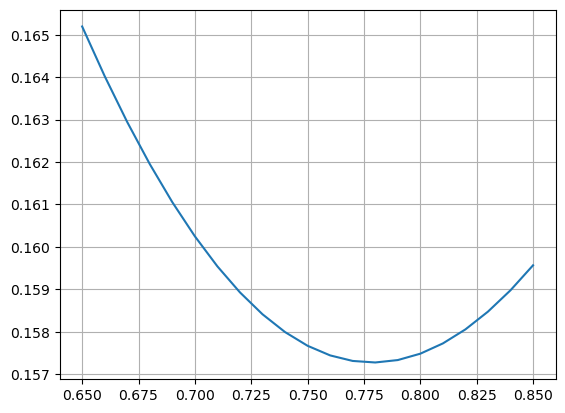

In [9]:
plt.plot(w_space, mean_scores)
plt.grid()
plt.show()

In [11]:
w = 0.78


model_election = BayesianRidge(fit_intercept = False)
election_features = ['result_house_2', 
                        'result_pres_4', 
                        'result_pres_8', 
                        'result_house_8',
                        'result_pres_12',
                        'result']

df_prev_election = df[election_features].dropna(how = 'any')

X_e = df_prev_election.drop(columns = 'result')
y_e = df_prev_election['result']
reg_e = model_election.fit(X_e, y_e)


model_demographic = BayesianRidge(fit_intercept = False)
demographic_features = ['bachelor_higher_pct',
                        'asian',
                        'unemployment_pct',
                        'unemployment_pct_1',
                        'white_evangelist_pct',
                        'result']

df_dem = df[demographic_features].dropna(how = 'any')

X_d = df_dem.drop(columns = 'result')
y_d = df_dem['result']
reg_d = model_demographic.fit(X_d, y_d)


df2024 = pd.read_csv('./training_data/2024-data.csv').set_index('state').fillna(0)
y_hat_e, y_hat_std_e = reg_e.predict(df2024[election_features[:-1]], return_std = True)
y_hat_d, y_hat_std_d = reg_d.predict(df2024[demographic_features[:-1]], return_std = True)

y_hat = w * y_hat_e + (1-w) * y_hat_d

mse = (w * y_hat_std_e) ** 2 + ((1-w) * y_hat_std_d) ** 2
mse_district = (w * y_hat_std_e) ** 2

prob = (1 - N(y_hat, np.sqrt(mse)).cdf(0)).round(5)

In [12]:
df_pred = pd.DataFrame(index = df2024.index)
df_pred.loc[:, 'logit prediction'] = y_hat
df_pred.loc[df_pred.index.str.len() > 3, 'logit prediction'] = y_hat_e[df_pred.index.str.len() > 3]

df_pred.loc[:, 'logit prediction mse'] = np.where(df_pred.index.str.len() > 3, mse_district, mse)
df_pred.loc[:, 'prediction'] = expit(df_pred['logit prediction'])
df_pred.loc[:, 'probability'] = (1 - N(df_pred['logit prediction'], np.sqrt(df_pred['logit prediction mse'])).cdf(0)).round(5)

df_pred = df_pred.drop(columns = ['logit prediction', 'logit prediction mse'])

In [13]:
df_pred

,prediction,probability
state,,
AK,0.518562,0.67775
AL,0.629626,0.99949
AR,0.644139,0.99988
AZ,0.500827,0.50821
CA,0.357803,0.00015
CO,0.423596,0.02863
CT,0.376264,0.00085
DC,0.081022,0.00000
DE,0.387412,0.00219


In [14]:
df_evs = pd.read_csv('./training_data/2024-evs.csv')

In [15]:
rand_matrix = np.random.uniform(0, 1, (1_000_000, len(df_pred)))

In [16]:
result_matrix = np.where((rand_matrix - df_pred['probability'].values < 0), 1, 0)

In [17]:
results = result_matrix @ df_evs['electoral_votes']

In [18]:
sum(results > 270)/len(results)

0.085882

In [19]:
sum(results == 270)/len(results)

0.006639

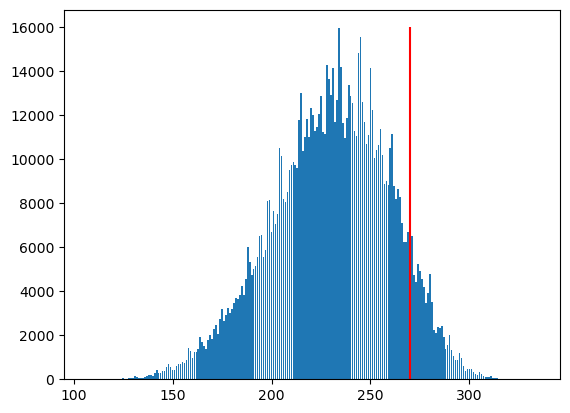

In [28]:
res, ct = np.unique(results, return_counts = True)

plt.bar(res, ct)
plt.vlines([270], 0, 16000, color = 'r')
plt.show()